In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
pd.set_option("display.max_columns",None)
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



In [13]:
dataset_path = "dataset.csv"
detection_data = pd.read_csv(dataset_path)

In [15]:

detection_data["Symptoms"] = detection_data.iloc[:, 1:18].apply(lambda row: row.dropna().tolist(), axis=1)
detection_data["Symptoms"] = detection_data["Symptoms"].apply(lambda x: [symptom.strip().lower().replace("_", " ") for symptom in x if symptom])


detection_data.loc[detection_data["Disease"] == "Common Cold", "Symptoms"] = detection_data.loc[detection_data["Disease"] == "Common Cold", "Symptoms"].apply(lambda x: x + ["anxiety"] if "anxiety" not in x else x)

In [17]:
detection_data.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,Symptoms
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin rash, nodal skin eruptions, dis..."
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[skin rash, nodal skin eruptions, dischromic ..."
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, nodal skin eruptions, dischromic pa..."
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin rash, dischromic patches]"
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin rash, nodal skin eruptions]"


In [19]:

mlb = MultiLabelBinarizer()
X = mlb.fit_transform(detection_data["Symptoms"])


disease_labels = detection_data["Disease"].astype("category")
y = disease_labels.cat.codes


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:

model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

disease_symptom_counts = detection_data.explode("Symptoms").groupby("Disease")["Symptoms"].value_counts().unstack(fill_value=0)
disease_major_symptoms = {}

for disease in disease_symptom_counts.index:
    symptom_frequencies = disease_symptom_counts.loc[disease].sort_values(ascending=False)
    threshold = max(2, symptom_frequencies.max() * 0.7)  # Major symptoms are frequent & unique
    major_symptoms = set(symptom_frequencies[symptom_frequencies >= threshold].index)
    disease_major_symptoms[disease] = major_symptoms


symptom_weights = {symptom: 1 for symptom in mlb.classes_}

for disease, major_symptoms in disease_major_symptoms.items():
    for symptom in major_symptoms:
        symptom_weights[symptom] = 6 


symptom_disease_counts = detection_data.explode("Symptoms").groupby("Symptoms")["Disease"].nunique()
high_overlap_symptoms = symptom_disease_counts[symptom_disease_counts > 5].index  # Appearing in >5 diseases

for symptom in high_overlap_symptoms:
    symptom_weights[symptom] = 1 


def clean_symptom(symptom):
    return " ".join(symptom.strip().lower().replace("_", " ").split())


def predict_disease_weighted(symptoms):
    symptoms = [clean_symptom(s) for s in symptoms]
    input_data = np.zeros(len(mlb.classes_))
    
    for symptom in symptoms:
        if symptom in mlb.classes_:
            index = np.where(mlb.classes_ == symptom)[0][0]
            input_data[index] = symptom_weights.get(symptom, 1)  
        else:
            print(f"⚠ Warning: Symptom '{symptom}' not found in model!")
    
    predicted_label = model.predict([input_data])[0]
    return disease_labels.cat.categories[predicted_label]

sample_symptoms = ["cough", "continuous_sneezing", "runny nose", "anxiety"]
print("Predicted Disease:", predict_disease_weighted(sample_symptoms))


Predicted Disease: Allergy


In [22]:

def predict_top2_diseases(symptoms):
    symptoms = [clean_symptom(s) for s in symptoms]
    input_data = np.zeros(len(mlb.classes_))
    
    for symptom in symptoms:
        if symptom in mlb.classes_:
            index = np.where(mlb.classes_ == symptom)[0][0]
            input_data[index] = symptom_weights.get(symptom, 1)  
        else:
            print(f"⚠ Warning: Symptom '{symptom}' not found in model!")
    
    probabilities = model.predict_proba([input_data])[0]
    

    top2_indices = np.argsort(probabilities)[-2:][::-1]
    
    
    top2_diseases = disease_labels.cat.categories[top2_indices]
    top2_probabilities = probabilities[top2_indices]
    
    return list(zip(top2_diseases, top2_probabilities))

sample_symptoms = ["cough", "continuous_sneezing", "runny nose", "anxiety"]
top2_predictions = predict_top2_diseases(sample_symptoms)

print("Top 2 Predicted Diseases:")
for i, (disease, prob) in enumerate(top2_predictions, 1):
    print(f"{i}. {disease} (Probability: {prob:.2f})")

Top 2 Predicted Diseases:
1. Allergy (Probability: 0.27)
2. Common Cold (Probability: 0.14)


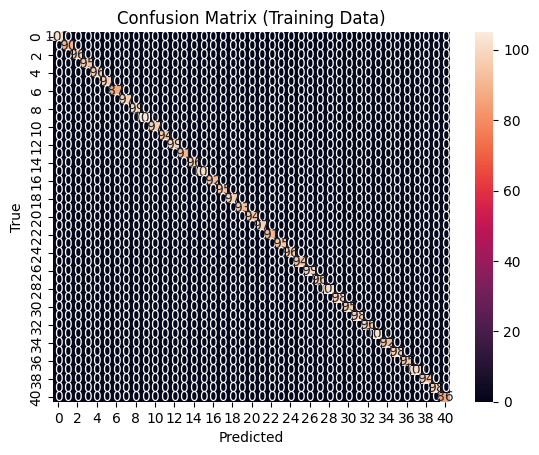

In [23]:
y_train_pred = model.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Training Data)')
plt.show()

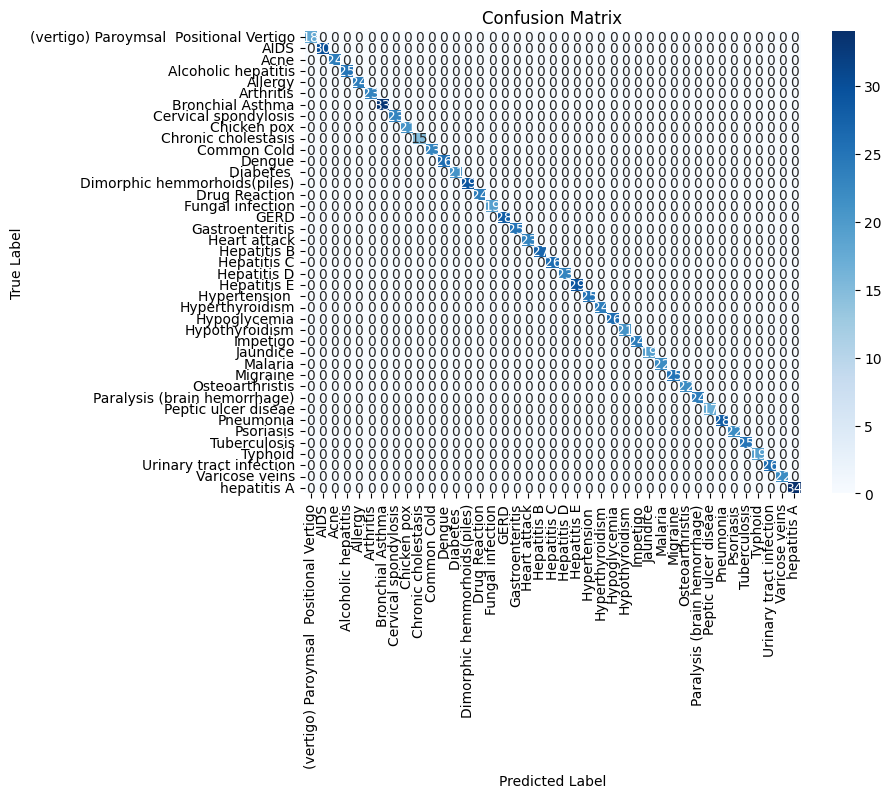

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test))

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=disease_labels.cat.categories, yticklabels=disease_labels.cat.categories)

# Labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show plot
plt.show()


In [29]:
# Calculate accuracy
accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 100.00%
